In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [5]:
train = train.drop(columns =['id'], axis=1)

In [6]:
# Summary of numerical columns
numaric_col = train.select_dtypes(include=[np.number]).columns.tolist()
numaric_col = [col for col in numaric_col if col not in ['id', 'diagnosed_diabetes']]
print(f" Numerical columns {len(numaric_col)}")
print(train[numaric_col].describe().T[['mean', 'std', 'min', 'max']].round(2))

 Numerical columns 18
                                      mean    std     min     max
age                                  50.36  11.66   19.00   89.00
alcohol_consumption_per_week          2.07   1.05    1.00    9.00
physical_activity_minutes_per_week   80.23  51.20    1.00  747.00
diet_score                            5.96   1.46    0.10    9.90
sleep_hours_per_day                   7.00   0.90    3.10    9.90
screen_time_hours_per_day             6.01   2.02    0.60   16.50
bmi                                  25.87   2.86   15.10   38.40
waist_to_hip_ratio                    0.86   0.04    0.68    1.05
systolic_bp                         116.29  11.01   91.00  163.00
diastolic_bp                         75.44   6.83   51.00  104.00
heart_rate                           70.17   6.94   42.00  101.00
cholesterol_total                   186.82  16.73  117.00  289.00
hdl_cholesterol                      53.82   8.27   21.00   90.00
ldl_cholesterol                     102.91  19.02   51

In [7]:
# Categorical columns info 
cat_col = train.select_dtypes(include=['object']).columns.tolist()
print(f'Number of Categorical columns: {len(cat_col)}')
print('='*60)

for col in cat_col:
    print(f'Column name: {col}')
    print(f'Number of unique values: {len(train[col].unique())}')
    print(f'Unique values: {train[col].unique()}')
    print()
    Summary =  train.groupby(col)['diagnosed_diabetes'].agg(
        count="count",
        mean="mean").sort_values(by='mean', ascending=False)
    print(Summary)
    print('-'*60)


Number of Categorical columns: 6
Column name: gender
Number of unique values: 3
Unique values: ['Female' 'Male' 'Other']

         count      mean
gender                  
Other     3678  0.640566
Male    333085  0.624294
Female  363237  0.622205
------------------------------------------------------------
Column name: ethnicity
Number of unique values: 5
Unique values: ['Hispanic' 'White' 'Asian' 'Black' 'Other']

            count      mean
ethnicity                  
Other       17442  0.635936
Asian       60120  0.628493
White      386153  0.624105
Black      106301  0.623879
Hispanic   129984  0.616314
------------------------------------------------------------
Column name: education_level
Number of unique values: 4
Unique values: ['Highschool' 'Graduate' 'Postgraduate' 'No formal']

                  count      mean
education_level                  
No formal         14945  0.636066
Graduate         261268  0.627008
Highschool       344145  0.621462
Postgraduate      79642  0.61

###### Highest Risk : "Low Income, No Formal Education, Gender: Other"   63.0% – 64.1%
###### Lowest Risk : "Middle Income, Postgraduate, Hispanic, Retired",   61.6% – 62.0%

In [8]:
# preprocessing 
# label encoding of features for tree-based algorithm
train_lb = train.copy()
label_encoders = {}

for col in cat_col:
    lab_encode = LabelEncoder()
    train_lb[col] = lab_encode.fit_transform(train[col].astype(str))
    label_encoders[col] = lab_encode


# one-hot encoding for regression-based algorithms 
train_one_hot = train.copy()
train_one_hot =  pd.get_dummies(train, columns=cat_col, drop_first = True)

In [9]:
# Defining X and y for label encoded data
X_lb = train_lb.drop(columns=['diagnosed_diabetes'])
y_lb = train_lb['diagnosed_diabetes']

# Defining X and y for one-hot encoded data
X_oh = train_one_hot.drop(columns=['diagnosed_diabetes'])
y_oh = train_one_hot['diagnosed_diabetes']

# Splitting train-test sets

X_lb_train, X_lb_test, y_lb_train, y_lb_test = train_test_split(X_lb, y_lb, test_size=0.25, random_state=40)
X_oh_train, X_oh_test, y_oh_train, y_oh_test = train_test_split(X_oh, y_oh, test_size=0.25, random_state=40)


Logistic Regression Accuracy Score : 0.6642
Classification Report :
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43     65926
         1.0       0.68      0.87      0.76    109074

    accuracy                           0.66    175000
   macro avg       0.64      0.60      0.59    175000
weighted avg       0.65      0.66      0.64    175000



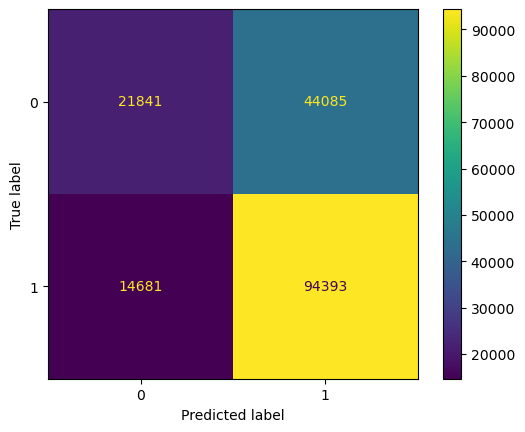

In [10]:
# Logistic Regression 
# Scale the data
scaler = StandardScaler()
X_oh_train_scaled = scaler.fit_transform(X_oh_train)
X_oh_test_scaled = scaler.transform(X_oh_test)

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_oh_train_scaled, y_oh_train)

# Predict
pred_lm = log_model.predict(X_oh_test_scaled)

# Accuracy
acc_score = accuracy_score(y_oh_test, pred_lm)
print(f"Logistic Regression Accuracy Score : {acc_score:.4f}")

# other matrix
print('Classification Report :')
print(classification_report(y_oh_test, pred_lm))
cm =  confusion_matrix(y_oh_test, pred_lm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Logistic Regression Accuracy Score : 0.6634
Classification Report :
              precision    recall  f1-score   support

         0.0       0.58      0.37      0.45     65926
         1.0       0.69      0.84      0.76    109074

    accuracy                           0.66    175000
   macro avg       0.64      0.61      0.61    175000
weighted avg       0.65      0.66      0.64    175000



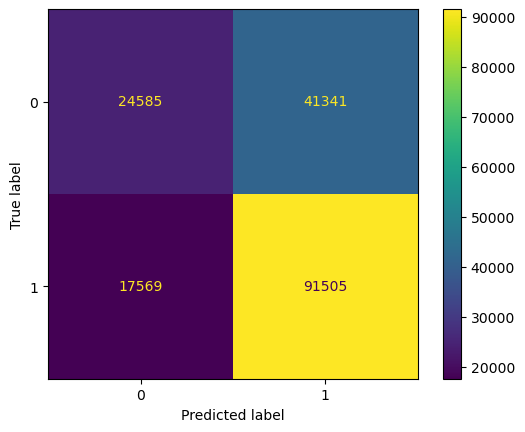

In [11]:
# RandomForest
# We are not using SVM since it is not appropriate for large data 
rf_model =  RandomForestClassifier(random_state=40)
rf_model.fit(X_lb_train, y_lb_train)
pred_rf =  rf_model.predict(X_lb_test)
# Accuracy
acc_score = accuracy_score(y_lb_test, pred_rf)
print(f"Logistic Regression Accuracy Score : {acc_score:.4f}")

# other matrix
print('Classification Report :')
print(classification_report(y_lb_test, pred_rf))
cm =  confusion_matrix(y_lb_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Logistic Regression Accuracy Score : 0.6738
Classification Report :
              precision    recall  f1-score   support

         0.0       0.61      0.36      0.45     65926
         1.0       0.69      0.86      0.77    109074

    accuracy                           0.67    175000
   macro avg       0.65      0.61      0.61    175000
weighted avg       0.66      0.67      0.65    175000



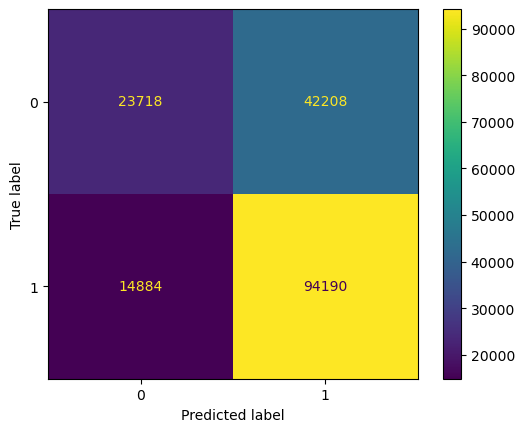

In [12]:
# GradientBoostingClassifier
gf_model = GradientBoostingClassifier(random_state = 42)
gf_model.fit(X_lb_test, y_lb_test)
pred_gf = gf_model.predict(X_lb_test)

# Accuracy
acc_score = accuracy_score(y_lb_test, pred_gf)
print(f"Logistic Regression Accuracy Score : {acc_score:.4f}")

# other matrix
print('Classification Report :')
print(classification_report(y_lb_test, pred_gf))
cm =  confusion_matrix(y_lb_test, pred_gf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


XGBoost Accuracy Score : 0.6821
Classification Report :
              precision    recall  f1-score   support

         0.0       0.62      0.41      0.49     65926
         1.0       0.70      0.85      0.77    109074

    accuracy                           0.68    175000
   macro avg       0.66      0.63      0.63    175000
weighted avg       0.67      0.68      0.66    175000



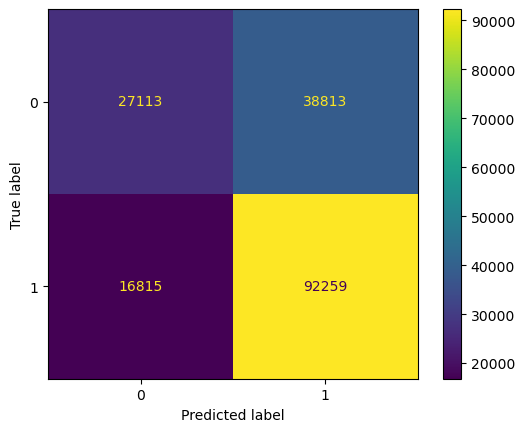

In [13]:
# XGBClassifier 
Xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# Train
Xgb_model.fit(X_lb_train, y_lb_train)

# Predict
pred_Xgb = Xgb_model.predict(X_lb_test)

# Accuracy
acc_score = accuracy_score(y_lb_test, pred_Xgb)
print(f"XGBoost Accuracy Score : {acc_score:.4f}")

# Other metrics
print('Classification Report :')
print(classification_report(y_lb_test, pred_Xgb))

# Confusion Matrix
cm = confusion_matrix(y_lb_test, pred_Xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


[LightGBM] [Info] Number of positive: 327233, number of negative: 197767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 525000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623301 -> initscore=0.503583
[LightGBM] [Info] Start training from score 0.503583
XGBoost Accuracy Score : 0.6824
Classification Report :
              precision    recall  f1-score   support

         0.0       0.62      0.41      0.49     65926
         1.0       0.70      0.85      0.77    109074

    accuracy                           0.68    175000
   macro avg       0.66      0.63      0.63    175000
weighted avg       0.67      0.68      0.67    175000



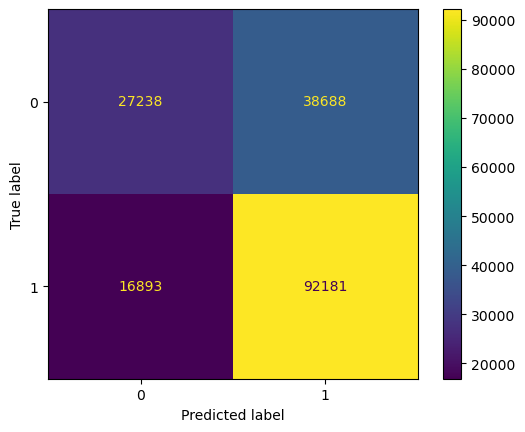

In [14]:
# LGBMClassifier 
lgbmc_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

lgbmc_model.fit(X_lb_train, y_lb_train)
pred_lgbmc = lgbmc_model.predict(X_lb_test)

# Accuracy
acc_score = accuracy_score(y_lb_test, pred_lgbmc)
print(f"XGBoost Accuracy Score : {acc_score:.4f}")

# Other metrics
print('Classification Report :')
print(classification_report(y_lb_test, pred_lgbmc))

# Confusion Matrix
cm = confusion_matrix(y_lb_test, pred_lgbmc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
                    

In [17]:
# HyperParameterTuning 
lgb = LGBMClassifier(random_state=42)
param_dist = {
    'num_leaves': np.arange(20, 200, 20),
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate':[0.1, 0.05, 0.01],
    'n_estimators':[200, 400, 600, 800],
    'subsample':[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'min_child_samples':[10, 20, 30, 50, 100],
    'reg_alpha':[0, 0.1, 1.5 ,1],
    'reg_lambda':[0.1, 0.5, 1, 5]
}

rs = RandomizedSearchCV(
    estimator=lgb,
    param_distributions= param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_lb_train, y_lb_train)

print("Best Parameters:" ,rs.best_params_)
print("Best CV Accuracy:" ,rs.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 218155, number of negative: 131845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623300 -> initscore=0.503579
[LightGBM] [Info] Start training from score 0.503579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [18]:
print("Best Parameters:", rs.best_params_)

Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1.5, 'num_leaves': np.int64(180), 'n_estimators': 800, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [19]:
print("Best CV Accuracy:", rs.best_score_)

Best CV Accuracy: 0.6845942857142857


XGBoost Accuracy Score : 0.6863
Classification Report :
              precision    recall  f1-score   support

         0.0       0.62      0.43      0.51     65926
         1.0       0.71      0.84      0.77    109074

    accuracy                           0.69    175000
   macro avg       0.67      0.64      0.64    175000
weighted avg       0.68      0.69      0.67    175000



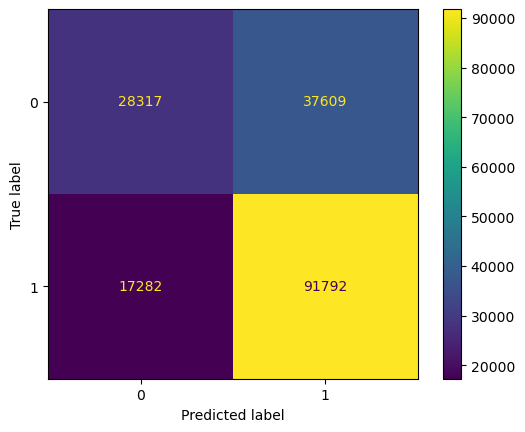

In [21]:
lgbmc = rs.best_estimator_
pred_lgbmc = lgbmc.predict(X_lb_test)

# Accuracy
acc_score = accuracy_score(y_lb_test, pred_lgbmc)
print(f"XGBoost Accuracy Score : {acc_score:.4f}")

# Other metrics
print('Classification Report :')
print(classification_report(y_lb_test, pred_lgbmc))

# Confusion Matrix
cm = confusion_matrix(y_lb_test, pred_lgbmc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [22]:
test_lb = test.copy()

for col in cat_col:
    lab_encode = label_encoders[col]
    test_lb[col] = lab_encode.transform(test[col].astype(str))

In [30]:
test_lb = test_lb.drop(columns=['id'], axis=1)

In [32]:
# Final prediction on test data for submission
lgbmc = LGBMClassifier(**rs.best_params_, random_state=42, verbose=-1)
lgbmc.fit(X_lb, y_lb)

pred_lgbmc = lgbmc.predict(test_lb)

In [33]:
submission = pd.DataFrame({
    'id': test['id'],
    'diagnosed_diabetes': pred_lgbmc.astype(int)
})

submission.to_csv('submission.csv', index=False)

print(f"Submission saved to 'submission.csv'")
print(f"Shape: {submission.shape}")
submission.head(10)

Submission saved to 'submission.csv'
Shape: (300000, 2)


,id,diagnosed_diabetes
0,700000,0
1,700001,1
2,700002,1
3,700003,0
4,700004,1
5,700005,1
6,700006,1
7,700007,1
8,700008,1
9,700009,1
